In [1]:
from fuzzy_art import *
from handytools import *
import sklearn.datasets as ds
import sklearn.decomposition as dcp
import matplotlib.pyplot as plt

In [2]:
iris = ds.load_iris()
data = iris['data'] / np.max(iris['data'], axis=0)
label_true = iris['target']
# pca
pca = dcp.PCA(n_components=2)
pca_xy = pca.fit_transform(data)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.92138578 0.05142129]
[4.9602239  1.17179601]


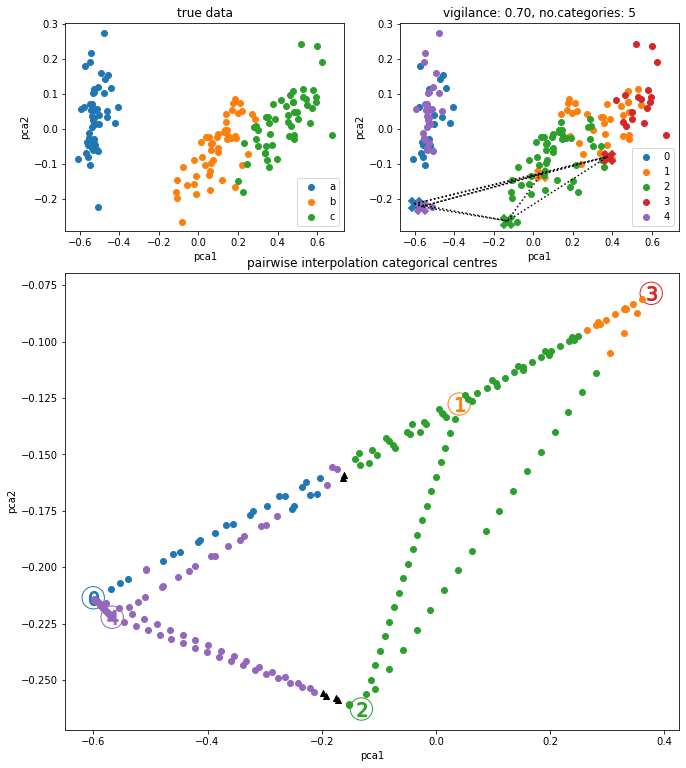

In [6]:
fig, axs = plt.subplot_mosaic("""
                                AB
                                CC
                                CC
                                """,
                                figsize=(11, 13))
#fig.tight_layout()

# plot true
for cat_true, lb_true in enumerate(('a', 'b', 'c')):
    axs['A'].scatter(*np.where(label_true == cat_true, pca_xy.T, None), label = lb_true)
axs['A'].set_title('true data')

# use FuzzyART
# init
rho = 0.7
net = FuzzyART(alpha=0.5, rho=rho) # for the current iris data, rho near 0.65 seems the best in clustering data

# train
net.train(data, epochs=100) # each epoch, all data is shuffled
label_pred = net.test(data).astype(int)

cat_number = net.w.shape[0]
replay_cat = net.w[:, :4]
cat_centre = pca.transform(replay_cat)

# plot cats
for cat_pred, cat_x, cat_y in zip(range(cat_number), *cat_centre.T):
    c = next(axs['B']._get_lines.prop_cycler)['color']
    axs['B'].scatter(*np.where(label_pred == cat_pred, pca_xy.T, None), color = c, label = cat_pred) # all training samples
    axs['B'].scatter(cat_x, cat_y, marker = 'X', s = 200, color = c) # categorical centre
    axs['C'].scatter(cat_x, cat_y, marker = 'o', s = 500, facecolor = 'none', edgecolor = c)
    axs['C'].scatter(cat_x, cat_y, marker = '${}$'.format(cat_pred), s = 200, color = c)
axs['B'].set_title('vigilance: {:.2f}, no.categories: {}'.format(rho, cat_number))

# plot inters
ls_interidx, ls_intercat = [], []
for i in range(cat_number):
    for j in range(i + 1, cat_number):
        interidx = np.array([i, j])
        ls_interidx.append(interidx) 
        axs['B'].plot(*cat_centre[interidx].T, c = 'k', ls = 'dotted')

        intercat = interp2coordinates(*replay_cat[interidx], 20)
        intercat_label = net.test(intercat).astype(int)
        ls_intercat.append(intercat_label)
        axs['B'].set_prop_cycle(None)
        for cat_pred in range(cat_number):
            c = next(axs['B']._get_lines.prop_cycler)['color']
            axs['C'].scatter(*np.where(intercat_label == cat_pred, pca.transform(intercat).T, None), color = c)
        axs['C'].scatter(*np.where(intercat_label == -1, pca.transform(intercat).T, None), color = 'k', marker = '^')

ls_intercat = np.array(ls_intercat)
axs['C'].set_title('pairwise interpolation categorical centres')

for idx in 'ABC':
    axs[idx].set_xlabel('pca1')
    axs[idx].set_ylabel('pca2')
    
for idx in 'AB':    
    axs[idx].legend()

In [7]:
simname = 'intercat'
dirname = '_simcache'
savefigure_datetime(fig, simname, dirname)

figure saved at _simcache/2022-03-17_14-40-26_intercat
